# Exercise: beam bending with the Galerkin method

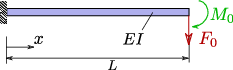

The differential equation for beam bending

$$
(EI w'')'' - q = 0 \text{ with } q = 0
$$

can be integrated analytically by specifying the boundary conditions

$$
w(0) = 0\\
w'(0) = 0\\
EIw''(L)=M_0\\
EIw'''(L) = -F_0
$$

to yield the deflection solution ("Biegelinie"):

$$
w(x) = \frac{F_0L^3}{3EI} \left[ 1 - \frac{3}{2}\frac{L-x}{L} + \frac{1}{2} \left( \frac{L-x}{L}\right)^3 \right] + \frac{M_0L^2}{2EI} \left[1 - 2\frac{L-x}{L} + \left( \frac{L-x}{L}\right)^2 \right] 
$$

Or you simply take the solutions for a force-loaded and a moment-loaded beam from a table and add them up. We now seek to approximate this solution numerically using Galerkin's method.

Additionally, for simplicity we assume proportionality between $F_0$ and $M_0$:

$$
M_0 = c F_0 L \text{ with } c = \text{const.}
$$

In [18]:
import numpy as np #numerical methods
import sympy as sp #symbolic operations
import matplotlib.pyplot as plt #plotting
sp.init_printing(use_latex='mathjax') #makes sympy output look nice

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True

In [19]:
#Defining the geometric an material characteristics as symbolic quantities
L,F,c,EI,x = sp.symbols('L F_0 c EI x')

In [20]:
#Analytical solution to deflection
def deflection_analytical():
    a = (L-x)/L
    f = F*L**3/EI
    force_contribution = f/3 * (1 - 3*a/2 + a**3/2)
    moment_contribution = c*f/2 * (1 - 2*a + a**2)
    return force_contribution + moment_contribution

In [21]:
deflection_analytical()#check definition

        ⎛                       2⎞         ⎛                       3⎞
    3   ⎜    2⋅(L - x)   (L - x) ⎟       3 ⎜    3⋅(L - x)   (L - x) ⎟
F₀⋅L ⋅c⋅⎜1 - ───────── + ────────⎟   F₀⋅L ⋅⎜1 - ───────── + ────────⎟
        ⎜        L           2   ⎟         ⎜       2⋅L           3  ⎟
        ⎝                   L    ⎠         ⎝                  2⋅L   ⎠
────────────────────────────────── + ────────────────────────────────
               2⋅EI                                3⋅EI              

Now, let's plot the analytical solution. For that purpose, we use some Python magic ("lambdify"). We sample the analytical solution for $x \in [0,L]$ at 100 points and plot the dimensionless deflection over the dimensionless length.

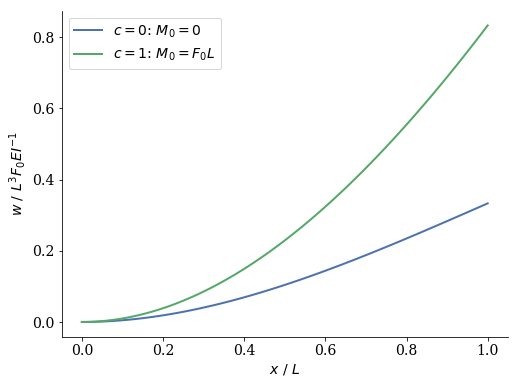

In [22]:
defl_c0 = sp.lambdify(x, deflection_analytical().subs(c,0), modules=['numpy'])#c=0
defl_c1 = sp.lambdify(x, deflection_analytical().subs(c,1), modules=['numpy'])#c=1
#For the variable x the function deflection_analytical() will obtain something

x_vals = np.linspace(0, 1, 100)*L #This something is x going from 0 to L
analytical_c0 = defl_c0(x_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical
analytical_c1 = defl_c1(x_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical

plt.plot(x_vals/L, analytical_c0/(L**3*F)*EI,label='$c=0$: $M_0 = 0$')
plt.plot(x_vals/L, analytical_c1/(L**3*F)*EI,label='$c=1$: $M_0 = F_0 L$')
plt.xlabel('$x\ /\ L$')
plt.ylabel('$w\ /\ L^3 F_0  EI^{-1}$')
plt.legend()

## Trigonometric Ansatz

Let's try the approximation

$$
    \tilde{w} = a \left[ 1 - \cos \left(\frac{\pi x}{4L}\right) \right]
$$

of the Ansatz function and the same expression but with a different coefficient for the test function (Bubnov-Galerkin)

$$
    \eta = b \left[ 1 - \cos \left(\frac{\pi x}{4L}\right) \right]
$$

Note, that in contrast to all previous examples we will only determine one value, since by definition the weak form has to hold for arbitrary $b$.

In [23]:
a, b = sp.symbols('a b')#Defining the free values as new symbols

In [24]:
def ansatz_function(): #\phi or \psi
    return (1-sp.cos(sp.pi/4*x/L))

def deflection_ansatz():
    return a*ansatz_function() #defining the approximate solution with the unknown coefficients

def test_ansatz():
    return b*ansatz_function()

The Galerkin scheme starts from the orthogonality condition / weighted-average formulation

$$
    0 = \int \limits_0^L \eta(x) \left[(EI\tilde{w}'')''\right]\,\text{d}x
$$
and proceeds with a two-fold partial integration and the use of the essential boundary conditions to arrive at (compare lecture notes for details):

$$
0 = \int \limits_0^L \left( EIw'' \eta''\right) \,\text{d} x -F_0 \eta(L) - M_0 \eta'(L)
$$

Generally, we had $\eta(x) = \sum \limits_{i=1}^n b_i \psi_i(x)$. Here we have $n=1$, and therefore

$$
    \eta = b\psi\, , \text{ with   } \psi = \left[ 1 - \cos \left(\frac{\pi x}{4L}\right) \right]
$$

Substitution into the weak form yields

$$
0 = b \left[ \int \limits_0^L \left( EIw'' \psi''\right) \,\text{d} x -F_0 \psi(L) - M_0 \psi'(L) \right] \ \forall b \neq 0
$$

Hence, we only solve one equation in this case!

In [25]:
weak_form = sp.integrate(EI * deflection_ansatz().diff(x,2) * ansatz_function().diff(x,2) , (x,0,L))
weak_form -= F * ansatz_function().subs(x,L)
weak_form -= c*F*L*ansatz_function().diff(x,1).subs(x,L)

We can simply solve this equation for the free coefficient $a$:

In [26]:
coefficients = sp.solve(weak_form,a)

In [27]:
coefficients[0]

⎧       3                                 
⎪32⋅F₀⋅L ⋅(√2⋅π⋅c - 4⋅√2 + 8)       π     
⎪────────────────────────────  for ─── = 0
⎪            4                     4⋅L    
⎪           π ⋅EI                         
⎨                                         
⎪       3                                 
⎪64⋅F₀⋅L ⋅(√2⋅π⋅c - 4⋅√2 + 8)             
⎪────────────────────────────   otherwise 
⎪        3                                
⎩       π ⋅EI⋅(2 + π)                     

In [28]:
solution = deflection_ansatz().subs(a,coefficients[0]).simplify()
solution

⎧       3 ⎛     ⎛π⋅x⎞    ⎞                                 
⎪32⋅F₀⋅L ⋅⎜- cos⎜───⎟ + 1⎟⋅(√2⋅π⋅c - 4⋅√2 + 8)             
⎪         ⎝     ⎝4⋅L⎠    ⎠                           π     
⎪─────────────────────────────────────────────  for ─── = 0
⎪                     4                             4⋅L    
⎪                    π ⋅EI                                 
⎨                                                          
⎪       3 ⎛     ⎛π⋅x⎞    ⎞                                 
⎪64⋅F₀⋅L ⋅⎜- cos⎜───⎟ + 1⎟⋅(√2⋅π⋅c - 4⋅√2 + 8)             
⎪         ⎝     ⎝4⋅L⎠    ⎠                                 
⎪─────────────────────────────────────────────   otherwise 
⎪                 3                                        
⎩                π ⋅EI⋅(2 + π)                             

Now we're ready to plot the result and compare it to the analytical solution. 

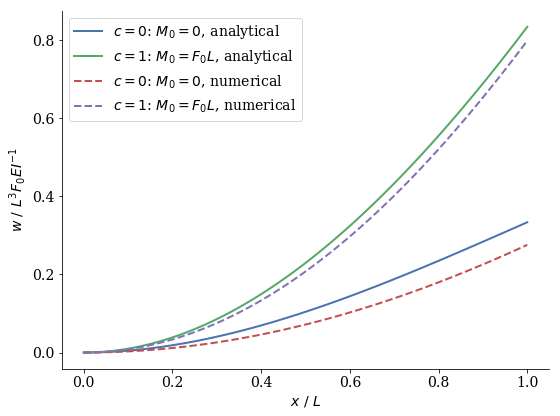

In [29]:
#We first substite the now known Ansatz free values into our Ansatz
z = sp.symbols('z')
w_numerical_c0 = solution.subs([(c,0),(x,z*L)])
w_numerical_c1 = solution.subs([(c,1),(x,z*L)])
#We also made the coordinate dimensionless (x/L --> z) because of sympy problems

lam_x_num_c0 = sp.lambdify(z, w_numerical_c0, modules=['numpy'])
lam_x_num_c1 = sp.lambdify(z, w_numerical_c1, modules=['numpy'])
#For the variable x the expression w_numerical will be given something
z_vals = np.linspace(0, 1,100) #This something is z from 0 to 1
numerical_c0 = lam_x_num_c0(z_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical
numerical_c1 = lam_x_num_c1(z_vals) #We calculate the solution by passing x = [0,...,L] to deflection_analytical

plt.plot(x_vals/L, analytical_c0/(L**3*F)*EI,label='$c=0$: $M_0 = 0$, analytical')
plt.plot(x_vals/L, analytical_c1/(L**3*F)*EI,label='$c=1$: $M_0 = F_0 L$, analytical')
plt.plot(z_vals, numerical_c0/(L**3*F)*EI,label='$c=0$: $M_0 = 0$, numerical',ls='--')
plt.plot(z_vals, numerical_c1/(L**3*F)*EI,label='$c=1$: $M_0 = F_0 L$, numerical',ls='--')
plt.legend()
plt.xlabel('$x\ /\ L$')
plt.ylabel('$w\ /\ L^3 F_0  EI^{-1}$')
plt.tight_layout()
plt.savefig('beam_galerkin.pdf')

In [30]:
print("Maximum absolute error for c=0: ", np.max(np.abs(analytical_c0/(L**3*F)*EI - numerical_c0/(L**3*F)*EI)))
print("Maximum absolute error for c=1: ", np.max(np.abs(analytical_c1/(L**3*F)*EI - numerical_c1/(L**3*F)*EI)))

Maximum absolute error for c=0:  0.0584504403529307
Maximum absolute error for c=1:  0.0358657946638069


We can also plot and compare the bending moment. Let's first find the analytical expression by symbolically differentiating the deflection expression twice to obtain $M(x) = -EI w''(x)$:

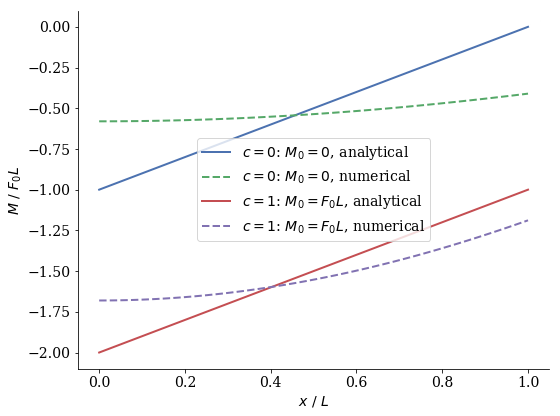

In [35]:
#analytical bending moment
moment_analytical = -deflection_analytical().diff(x,2)*EI
#numerical bending moment
moment_numerical = -solution.diff(x,2)*EI

#create lambdas for plotting along dimensionless length z
lam_x_analyt_c0 = sp.lambdify(z, moment_analytical.subs([(x,z*L),(c,0)]), modules=['numpy'])
lam_x_num_c0 = sp.lambdify(z, moment_numerical.subs([(x,z*L),(c,0)]), modules=['numpy'])
lam_x_analyt_c1 = sp.lambdify(z, moment_analytical.subs([(x,z*L),(c,1)]), modules=['numpy'])
lam_x_num_c1 = sp.lambdify(z, moment_numerical.subs([(x,z*L),(c,1)]), modules=['numpy'])

z_vals = np.linspace(0, 1,100)
analytical_c0 = lam_x_analyt_c0(z_vals)
numerical_c0 = lam_x_num_c0(z_vals)
analytical_c1 = lam_x_analyt_c1(z_vals)
numerical_c1 = lam_x_num_c1(z_vals)


#plot
plt.plot(x_vals/L, analytical_c0/(L*F),label='$c=0$: $M_0 = 0$, analytical')
plt.plot(z_vals, numerical_c0/(L*F),label='$c=0$: $M_0 = 0$, numerical',ls='--')
plt.plot(x_vals/L, analytical_c1/(L*F),label='$c=1$: $M_0 = F_0L$, analytical')
plt.plot(z_vals, numerical_c1/(L*F),label='$c=1$: $M_0 = F_0L$, numerical',ls='--')
plt.xlabel('$x\ /\ L$')
plt.ylabel('$M\ /\ F_0 L$')
plt.legend()
plt.tight_layout()
plt.savefig('beam_galerkin_moment.pdf')

In [32]:
print("Maximum absolute error in bending moment for c=0: ", np.max(np.abs(analytical_c0/(L*F) - numerical_c0/(L*F))))
print("Maximum absolute error in bending moment for c=1: ", np.max(np.abs(analytical_c1/(L*F) - numerical_c1/(L*F))))

Maximum absolute error in bending moment for c=0:  0.419754533346493
Maximum absolute error in bending moment for c=1:  0.319540138582482


*Tasks:*
- Why to the moment predictions seem worse compared to the other examples?
- What is the physical significance of the terms in the weak form?
- What happens with a full polynomial Ansatz containing orders 3 and 5?

In [33]:
work_balance=sp.integrate(-moment_numerical.subs(c,1)*ansatz_function().diff(x,2),(x,0,L))- F * ansatz_function().subs(x,L) - F*L*ansatz_function().diff(x,1).subs(x,L)

In [34]:
work_balance.simplify()

0